In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import text,sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D,GlobalMaxPooling1D,MaxPooling1D
from sklearn.model_selection import train_test_split
import re    #for regex
import string
from tensorflow import keras
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TengkaiGao\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [89]:
train = pd.read_csv('G:/toxic_final.csv')

In [90]:
train

,Unnamed: 0,Unnamed: 0.1,comment_text,Toxic
0,0,61,discussion requires both parties to explain th...,0
1,1,40630,avoiding edit wars acroterion i have been tr...,0
2,2,12124,omg i have never thought of it that way pure g...,0
3,3,11380,because of our recent edits to skycable the us...,0
4,4,5844,no harm done i deleted the second comment,0
...,...,...,...,...
41034,41034,43459,new mutants putlocker about to be the google ...,1
41035,41035,43460,it was better than the new mutants there were ...,1
41036,41036,43461,whenever i think that I am truly fast furious...,1
41037,41037,43462,my man was not to happy i left on this harley ...,1


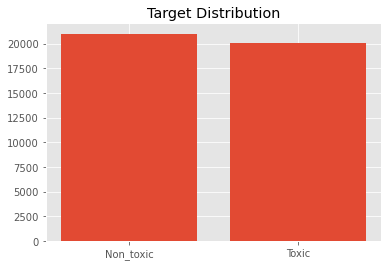

In [91]:
target_count = train.groupby('Toxic').size().reset_index(name='counts')
plt.bar(target_count.Toxic, target_count.counts)
plt.xticks([0,1], labels=["Non_toxic", "Toxic"])
plt.title("Target Distribution")
plt.show()

In [92]:
train['comment_text'] = pd.DataFrame(train["comment_text"].astype('str')) #transfomer to str 

In [93]:
x=train["comment_text"]
y=train["Toxic"]

In [94]:
#Splitting the data into train and test
train_x, test_x, train_y, test_y = train_test_split(x,y, test_size=0.2, random_state=1,shuffle=True)

In [95]:
max_feature = 3000#max feature 3000
tokenizer = tf.keras.preprocessing.text.Tokenizer(max_feature,
                                                  lower= True,
                                                  filters= '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                                  split = " ")#tokenizer 

tokenizer.fit_on_texts(train_x)

In [96]:
sequences = tokenizer.texts_to_sequences(train_x)

In [97]:
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences,
                                                             maxlen = 500)

In [98]:
test_x_tokenized=tokenizer.texts_to_sequences(test_x)
x_testing=tf.keras.preprocessing.sequence.pad_sequences(test_x_tokenized,maxlen=500)

In [99]:
pad_sequences

array([[   0,    0,    0, ...,   36, 2045,  247],
       [   0,    0,    0, ...,  145,    2,  324],
       [   0,    0,    0, ...,  411,  356,   25],
       ...,
       [   0,    0,    0, ...,  582,    3,  202],
       [   0,    0,    0, ...,    9,   95,  179],
       [   0,    0,    0, ...,    4,   28,   12]])

In [101]:
model_lstm = tf.keras.Sequential([tf.keras.layers.Embedding(max_feature,64,input_length = 500),
                                 tf.keras.layers.Dropout(0.3),
                                 tf.keras.layers.LSTM(64),
                                 tf.keras.layers.Dropout(0.3),
                                 tf.keras.layers.Dense(1, activation = "sigmoid")]
                                )

model_lstm.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 500, 64)           192000    
_________________________________________________________________
dropout_22 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_23 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 225,089
Trainable params: 225,089
Non-trainable params: 0
_________________________________________________________________


In [102]:
callback=keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=5, verbose=2, mode='auto', restore_best_weights=True)


In [103]:
model_lstm.compile(loss = "binary_crossentropy",
                 optimizer = tf.keras.optimizers.Adam(3e-3),
                 metrics= ["accuracy"])

In [104]:
history = model_lstm.fit(
    pad_sequences,train_y,
    batch_size= 64,
    epochs= 20,
    validation_split= 0.1,
    verbose=1,callbacks=[callback]
)

Epoch 1/20
462/462 [==============================] - 18s 34ms/step - loss: 0.3035 - accuracy: 0.8725 - val_loss: 0.2425 - val_accuracy: 0.8992
Epoch 2/20
462/462 [==============================] - 15s 33ms/step - loss: 0.2028 - accuracy: 0.9187 - val_loss: 0.2487 - val_accuracy: 0.9035curacy: 
Epoch 3/20
462/462 [==============================] - 15s 33ms/step - loss: 0.1830 - accuracy: 0.9281 - val_loss: 0.2542 - val_accuracy: 0.9019
Epoch 4/20
462/462 [==============================] - 15s 33ms/step - loss: 0.1642 - accuracy: 0.9356 - val_loss: 0.2559 - val_accuracy: 0.9086
Epoch 5/20
462/462 [==============================] - 15s 33ms/step - loss: 0.1486 - accuracy: 0.9408 - val_loss: 0.2664 - val_accuracy: 0.9074
Epoch 6/20
462/462 [==============================] - 15s 33ms/step - loss: 0.1500 - accuracy: 0.9411 - val_loss: 0.2900 - val_accuracy: 0.9065
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping


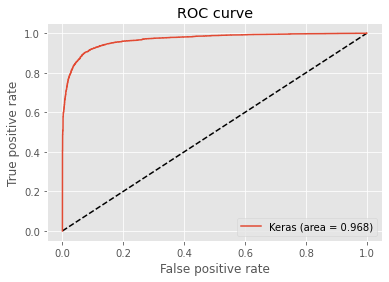

In [105]:
from sklearn.metrics import roc_curve
y_pred=model_lstm.predict(x_testing)
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [106]:
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
import numpy as np
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
y=tpr-fpr
idx=np.argmax(y)#Youden_index
best_threshold=thresholds[idx]
print("The best threshold is",best_threshold)
print(classification_report(test_y, y_pred >best_threshold ,digits=4))

The best threshold is 0.50681406
              precision    recall  f1-score   support

           0     0.9109    0.9247    0.9177      4234
           1     0.9184    0.9036    0.9110      3974

    accuracy                         0.9145      8208
   macro avg     0.9147    0.9141    0.9143      8208
weighted avg     0.9145    0.9145    0.9144      8208



In [33]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

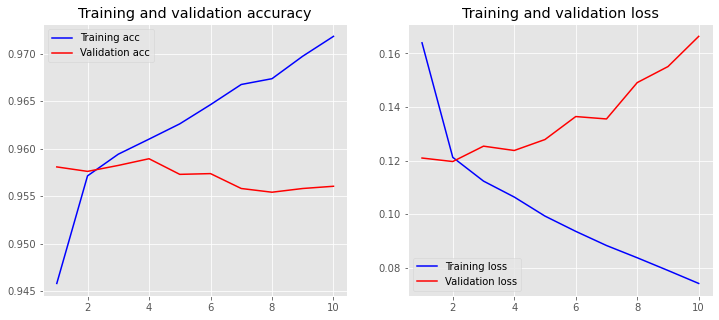

In [34]:
plot_history(history)

In [107]:
model_stack_lstm = tf.keras.Sequential([tf.keras.layers.Embedding(max_feature,64,input_length = 500),
                                tf.keras.layers.Dropout(0.3),
                                 tf.keras.layers.LSTM(64,return_sequences = True),
                                 tf.keras.layers.Dropout(0.3),
                                 tf.keras.layers.LSTM(64),
                                 tf.keras.layers.Dense(1, activation = "sigmoid")]
                                )

model_stack_lstm .summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 500, 64)           192000    
_________________________________________________________________
dropout_24 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 500, 64)           33024     
_________________________________________________________________
dropout_25 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 258,113
Trainable params: 258,113
Non-trainable params: 0
_______________________________________________

In [108]:
model_stack_lstm.compile(loss = "binary_crossentropy",
                 optimizer = tf.keras.optimizers.Adam(3e-3),
                 metrics= ["accuracy"])

In [109]:
history = model_stack_lstm.fit(
    pad_sequences,train_y,
    batch_size= 64,
    epochs= 20,
    validation_split= 0.1,
    verbose=1,callbacks=[callback]
)

Epoch 1/20
462/462 [==============================] - 34s 64ms/step - loss: 0.3021 - accuracy: 0.8718 - val_loss: 0.2444 - val_accuracy: 0.9013
Epoch 2/20
462/462 [==============================] - 29s 63ms/step - loss: 0.2035 - accuracy: 0.9187 - val_loss: 0.2317 - val_accuracy: 0.9068
Epoch 3/20
462/462 [==============================] - 29s 63ms/step - loss: 0.1843 - accuracy: 0.9270 - val_loss: 0.2510 - val_accuracy: 0.9041
Epoch 4/20
462/462 [==============================] - 29s 63ms/step - loss: 0.1711 - accuracy: 0.9315 - val_loss: 0.2539 - val_accuracy: 0.9010
Epoch 5/20
462/462 [==============================] - 29s 62ms/step - loss: 0.1559 - accuracy: 0.9358 - val_loss: 0.2443 - val_accuracy: 0.9077
Epoch 6/20
462/462 [==============================] - 29s 63ms/step - loss: 0.1394 - accuracy: 0.9429 - val_loss: 0.2688 - val_accuracy: 0.9056
Epoch 7/20
462/462 [==============================] - 29s 63ms/step - loss: 0.1448 - accuracy: 0.9419 - val_loss: 0.2636 - val_accuracy:

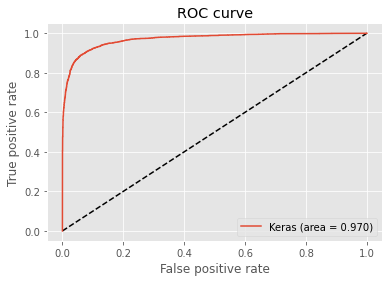

In [110]:
from sklearn.metrics import roc_curve
y_pred=model_stack_lstm.predict(x_testing)
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [111]:
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
import numpy as np
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
y=tpr-fpr
idx=np.argmax(y)#Youden_index
best_threshold=thresholds[idx]
print("The best threshold is",best_threshold)
print(classification_report(test_y, y_pred >best_threshold ,digits=4))

The best threshold is 0.6011906
              precision    recall  f1-score   support

           0     0.9000    0.9400    0.9196      4234
           1     0.9329    0.8888    0.9103      3974

    accuracy                         0.9152      8208
   macro avg     0.9165    0.9144    0.9150      8208
weighted avg     0.9160    0.9152    0.9151      8208



In [112]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
bi_model=Sequential()
bi_model.add(Embedding(max_feature,64,input_length = 500))
bi_model.add(Bidirectional(LSTM(64,return_sequences=True)))
bi_model.add(Dropout(0.3))
bi_model.add(Bidirectional(LSTM(64))) #lstm with 100 neurons
bi_model.add(Dense(1,activation='sigmoid'))
bi_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(3e-3),metrics=['accuracy'])
print(bi_model.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 500, 64)           192000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 500, 128)          66048     
_________________________________________________________________
dropout_26 (Dropout)         (None, 500, 128)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 356,993
Trainable params: 356,993
Non-trainable params: 0
_________________________________________________________________
None


In [113]:
history = bi_model.fit(
    pad_sequences,train_y,
    batch_size= 64,
    epochs= 20,
    validation_split= 0.1,
    verbose=1,callbacks=[callback]
)

Epoch 1/20
462/462 [==============================] - 70s 127ms/step - loss: 0.3079 - accuracy: 0.8719 - val_loss: 0.2621 - val_accuracy: 0.8867
Epoch 2/20
462/462 [==============================] - 57s 124ms/step - loss: 0.2218 - accuracy: 0.9137 - val_loss: 0.2357 - val_accuracy: 0.9032
Epoch 3/20
462/462 [==============================] - 57s 123ms/step - loss: 0.1870 - accuracy: 0.9270 - val_loss: 0.2464 - val_accuracy: 0.9013
Epoch 4/20
462/462 [==============================] - 57s 124ms/step - loss: 0.1737 - accuracy: 0.9321 - val_loss: 0.2456 - val_accuracy: 0.9071
Epoch 5/20
462/462 [==============================] - 58s 125ms/step - loss: 0.1553 - accuracy: 0.9390 - val_loss: 0.2403 - val_accuracy: 0.9062
Epoch 6/20
462/462 [==============================] - 58s 125ms/step - loss: 0.1367 - accuracy: 0.9469 - val_loss: 0.3035 - val_accuracy: 0.8992
Epoch 7/20
462/462 [==============================] - 57s 124ms/step - loss: 0.1229 - accuracy: 0.9522 - val_loss: 0.2995 - val_ac

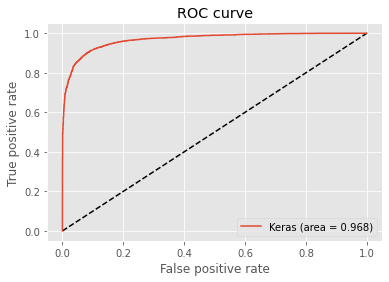

In [114]:
from sklearn.metrics import roc_curve
y_pred=bi_model.predict(x_testing)
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [115]:
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
import numpy as np
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
y=tpr-fpr
idx=np.argmax(y)#Youden_index
best_threshold=thresholds[idx]
print("The best threshold is",best_threshold)
print(classification_report(test_y, y_pred >best_threshold ,digits=4))

The best threshold is 0.36545476
              precision    recall  f1-score   support

           0     0.9160    0.9091    0.9125      4234
           1     0.9039    0.9112    0.9075      3974

    accuracy                         0.9101      8208
   macro avg     0.9099    0.9101    0.9100      8208
weighted avg     0.9101    0.9101    0.9101      8208

